In [1]:
# Imports
import torch


torch.cuda.empty_cache()
torch.manual_seed(0)
from torch.nn.functional import interpolate


from hr_dv2 import HighResDV2, torch_pca
import hr_dv2.transform as tr
from hr_dv2.utils import *
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import Normalize, AsinhNorm, LogNorm
from skimage.color import rgb2gray

from featup.util import norm, unnorm
use_norm = True

/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
C = 384
L = 518

In [3]:
def load_img(path: str) -> tuple[torch.Tensor, np.ndarray]:
    temp_img = Image.open(path)
    h, w = temp_img.height, temp_img.width
    transform = tr.get_input_transform(L, L)
    tensor, img = tr.load_image(path, transform)
    H, W = img.height, img.width
    return tensor, np.array(img)

In [4]:
inp_tensor, inp_arr = load_img('fig_data/cones_input.jpg')
targ_tensor, targ_arr = load_img('fig_data/cones_target.jpg')

inp_tensor, targ_tensor = inp_tensor.cuda(), targ_tensor.cuda()

/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
def add_inset_zoom(xywh: list[int], fig_xywh: list[float], img_arr: np.ndarray, ax ) -> object:
    x0, y0, w, h = xywh
    fx, fy, fw, fh = fig_xywh
    H, W, C = img_arr.shape
    inset_data = np.zeros_like(img_arr)
    inset_data[y0:y0+h, x0:x0+w, :] = img_arr[y0:y0+h, x0:x0+w, :]
    extent = (0, H, W, 0)
    # 418 / 518, 0 / 518, 150 / 518, 150 / 518
    axin = ax.inset_axes(
        fig_xywh, xlim=(x0, x0+w), ylim=(y0, y0+h))
    axin.set_axis_off()
    axin.imshow(inset_data)
    ax.indicate_inset_zoom(axin, edgecolor="r", lw=2)
    axin.set_ylim((y0 + h, y0))
    return axin


In [6]:
net = HighResDV2("dinov2_vits14_reg", 4, dtype=torch.float16) #dino_vits8 #dinov2_vits14_reg
net.interpolation_mode = 'nearest-exact'
net.cuda()

fwd_shift, inv_shift = tr.get_shift_transforms([1, 2], 'Moore')
fwd_flip, inv_flip = tr.get_flip_transforms()
fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [7]:
C = net.feat_dim

In [8]:
out = [] # format si, st, oi, ot

for i in range(3):
    if i == 0:
        net.set_transforms([], [])
    elif i == 1:
        net.set_transforms(fwd, inv)
    else:
        net = torch.hub.load("mhamilton723/FeatUp", 'dinov2', use_norm=use_norm)
        net.cuda()

    for img_tensor in [inp_tensor, targ_tensor]:
        if i == 2:
            tensor = img_tensor.unsqueeze(0)

        else:
            tensor = img_tensor
        feats = net.forward(tensor)
        if i == 2:
            feats = interpolate(feats, (L, L))
        feats_np = tr.to_numpy(feats)
        out.append(feats_np)

Using cache found in /home/ronan/.cache/torch/hub/mhamilton723_FeatUp_main
/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/featup-0.1.2-py3.10-linux-x86_64.egg/featup/featurizers/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/featup-0.1.2-py3.10-linux-x86_64.egg/featup/featurizers/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/featup-0.1.2-py3.10-linux-x86_64.egg/featup/featurizers/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/HR-Dv2/.venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will 

In [9]:
def get_most_similar_point(qx: int, qy: int, inp_2D: np.ndarray, flat_target: np.ndarray) -> tuple[int, int, np.ndarray]:
    query_vec = inp_2D[:, qy, qx]
    sim = np.dot(query_vec, flat_target)
    sim_2D = sim.reshape((L, L))

    max_sim_idx = np.argmax(sim_2D)
    SY, SX = max_sim_idx // L, max_sim_idx % L  
    return SX, SY, sim_2D


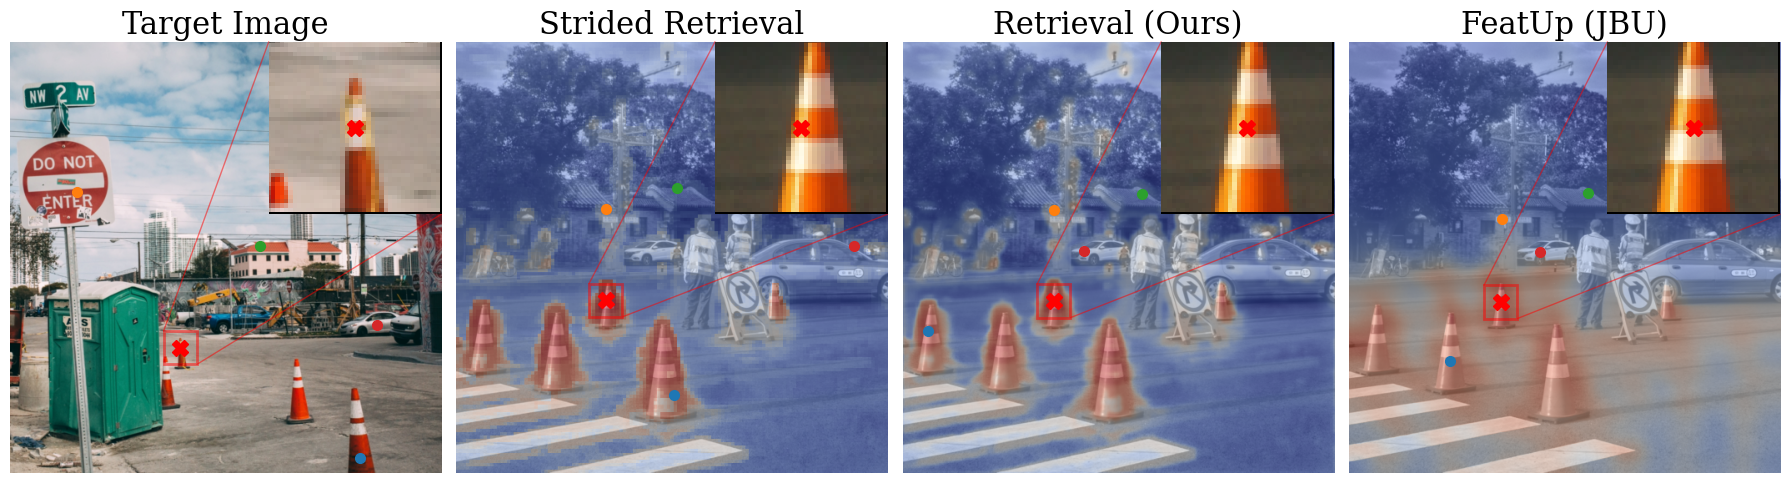

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=4)

fig.set_size_inches(18, 8)
plt.rcParams["font.family"] = "serif"

cross_s, dot_s = 12, 14

titles = ["Query Point", "Target Image", "Strided Retrieval", "Retrieval (Ours)", "FeatUp (JBU)", "foo"]
for i in range(-1, 3):
    ax = axs[i+1]#axs[(i + 2) // 2, (i + 2) % 2]
    ax.set_title(titles[i + 2], fontsize=22)
    ax.set_axis_off()
    if i == -1:
        ax.imshow(inp_arr)
        QX, QY = 204, 367
        ax.plot(QX, QY, marker="X", ms=cross_s, color='r')

        other_points = [(420, 500), (80, 180), (300, 245), (440, 340)]

        for p in other_points:
            ax.plot(p[0], p[1], marker=".", ms=dot_s)

        xywh = [QX - 20, QY - 20, 40, 40]
        fxywh = [0.6, 0.6, 0.4, 0.4]

        axin = add_inset_zoom(xywh, fxywh, inp_arr, ax)
        axin.plot(QX, QY, marker="X", ms=cross_s, color='r')
    else:
        SX, SY, sim_2D = get_most_similar_point(QX, QY, out[i * 2], out[(i * 2) + 1].reshape((C, -1)))

        for p in other_points:
            sx, sy, _ = get_most_similar_point(p[0], p[1], out[i * 2], out[(i * 2) + 1].reshape((C, -1)))
            ax.plot(sx, sy, marker=".", ms=dot_s)
        
        ax.plot(SX, SY, marker="X", ms=cross_s, color='r')
        norm = Normalize()
        colors = colormaps['coolwarm'](norm(sim_2D))
        #greyscale_arr = np.expand_dims(rgb2gray(targ_arr), -1)

        greyscale_pil = Image.fromarray(targ_arr).convert('L').convert('RGB')
        rgb_cmap = Image.fromarray((colors[:, :, :3] * 255).astype(np.uint8))


        img = Image.blend(greyscale_pil, rgb_cmap, 0.5)
        ax.imshow(img)

        txywh = [SX - 20, SY - 20, 40, 40]
        tfxywh = [0.6, 0.6, 0.4, 0.4]
        t_axin = add_inset_zoom(txywh, tfxywh, targ_arr, ax)
        t_axin.plot(SX, SY, marker="X", ms=cross_s, color='r')
plt.tight_layout()
plt.savefig('fig_out/retrieval_d2_s4.png')